In [20]:
import pandas as pd
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


import xgboost as xgb
from catboost import CatBoostRegressor

In [22]:
train = pd.read_csv('train_cleaned.csv')
test = pd.read_csv('test_cleaned.csv')

In [24]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450.0,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600.0,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250.0,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550.0,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260.0,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [25]:
x_train = train.drop(["SalePrice", "Id"], axis=1)
y_train = train["SalePrice"]

x_test = test.drop("Id", axis=1)

In [26]:
x_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,65.0,11622.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,80.0,14267.0,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,0,6,2010,WD,Normal
2,60,RL,68.0,13830.0,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,60.0,9978.0,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,84.0,5005.0,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,1,2010,WD,Normal


#### Data Preprocessing

In [28]:
#Seperating numerical and categorical columns
num_cols = [features for features in x_train.columns if x_train[features].dtype != 'O']
cat_cols = [features for features in x_train.columns if x_train[features].dtype == 'O']

#### Encoding Categorical Values and Handling missing data

In [29]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # Fill missing numerics with median
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing categoricals with mode
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Full preprocessor
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])


#### Function To Evaluate Model

In [30]:
def evaluate_model(model, X, y):
    """Wrap regressor with preprocessing and evaluate using CV"""
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    mae = -cross_val_score(pipeline, X, y, cv=kf,
                           scoring=make_scorer(mean_absolute_error, greater_is_better=False)).mean()
    rmse = np.sqrt(-cross_val_score(pipeline, X, y, cv=kf,
                                    scoring=make_scorer(mean_squared_error, greater_is_better=False)).mean())
    r2 = cross_val_score(pipeline, X, y, cv=kf, scoring="r2").mean()
    return mae, rmse, r2

#### Training Multiple Model 

In [31]:
results = {}

# Linear Regression
results["Linear Regression"] = evaluate_model(LinearRegression(), x_train, y_train)

# Decision Tree
results["Decision Tree"] = evaluate_model(DecisionTreeRegressor(random_state=42), x_train, y_train)

# Random Forest 
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(x_train, y_train)
results["Random Forest"] = evaluate_model(rf_pipeline.named_steps["regressor"], x_train, y_train)

# Gradient Boosting
results["Gradient Boosting"] = evaluate_model(GradientBoostingRegressor(random_state=42), x_train, y_train)

# XGBoost
results["XGBoost"] = evaluate_model(xgb.XGBRegressor(random_state=42,
                                                     n_estimators=500,
                                                     learning_rate=0.05,
                                                     max_depth=4,
                                                     n_jobs=-1),
                                    x_train, y_train)

# CatBoost
results["CatBoost"] = evaluate_model(CatBoostRegressor(iterations=500,
                                                       learning_rate=0.05,
                                                       depth=6,
                                                       random_seed=42,
                                                       verbose=0),
                                     x_train, y_train)

#Result
df_results = pd.DataFrame(results, index=["MAE", "RMSE", "R²"]).T
print("\nModel Comparison Results:\n")
print(df_results)



Model Comparison Results:

                            MAE          RMSE        R²
Linear Regression  14955.827187  23056.871373  0.880207
Decision Tree      23236.225685  33149.498026  0.753725
Random Forest      15719.791353  22870.033005  0.882081
Gradient Boosting  14422.232966  21403.859442  0.896212
XGBoost            13889.549979  20802.999666  0.902092
CatBoost           13008.189196  19491.933818  0.914182


In [32]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

rf = Pipeline(steps=[("preprocessor", preprocessor),
                    ("model", RandomForestRegressor(random_state=42))])

rf_params = {
    "model__n_estimators": [100, 300, 500],
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2"]
}

rf_grid = RandomizedSearchCV(rf, rf_params,
                             n_iter=20,
                             cv=5,
                             scoring="neg_mean_squared_error",
                             n_jobs=-1,
                             random_state=42,
                             verbose=2)

rf_grid.fit(x_train, y_train)
print("Best RF Params:", rf_grid.best_params_)

# ---------------------------
# CatBoost Tuning (CatBoost handles categoricals natively)
# ---------------------------

cat_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),  # handles numeric + categorical
    ("model", CatBoostRegressor(random_state=42, silent=True))
])

# Parameter grid (use model__ prefix because CatBoost is inside a pipeline)
cat_params = {
    "model__iterations": [500, 1000],
    "model__depth": [6, 8, 10],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__l2_leaf_reg": [1, 3, 5, 7]
}

# RandomizedSearchCV
cat_grid = RandomizedSearchCV(cat_pipeline, cat_params,
                              n_iter=10,
                              cv=5,
                              scoring="neg_mean_squared_error",
                              n_jobs=-1,
                              random_state=42,
                              verbose=2)

# Fit the model
cat_grid.fit(x_train, y_train)

# Best parameters
print("Best CatBoost Params:", cat_grid.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF Params: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 20}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best CatBoost Params: {'model__learning_rate': 0.05, 'model__l2_leaf_reg': 3, 'model__iterations': 500, 'model__depth': 6}


In [33]:

# Evaluate Random Forest with cross-validation
rf_best = rf_grid.best_estimator_

mae_rf = -cross_val_score(rf_best, x_train, y_train,
                          cv=5,
                          scoring=make_scorer(mean_absolute_error, greater_is_better=False)).mean()
rmse_rf = np.sqrt(-cross_val_score(rf_best, x_train, y_train,
                                   cv=5,
                                   scoring=make_scorer(mean_squared_error, greater_is_better=False)).mean())
r2_rf = cross_val_score(rf_best, x_train, y_train, cv=5, scoring='r2').mean()

print("Random Forest CV Performance:")
print(f"MAE  : {mae_rf:.2f}")
print(f"RMSE : {rmse_rf:.2f}")
print(f"R²   : {r2_rf:.4f}")

# Evaluate CatBoost with cross-validation
cat_best = cat_grid.best_estimator_

mae_cat = -cross_val_score(cat_best, x_train, y_train,
                           cv=5,
                           scoring=make_scorer(mean_absolute_error, greater_is_better=False)).mean()
rmse_cat = np.sqrt(-cross_val_score(cat_best, x_train, y_train,
                                    cv=5,
                                    scoring=make_scorer(mean_squared_error, greater_is_better=False)).mean())
r2_cat = cross_val_score(cat_best, x_train, y_train, cv=5, scoring='r2').mean()

print("\nCatBoost CV Performance:")
print(f"MAE  : {mae_cat:.2f}")
print(f"RMSE : {rmse_cat:.2f}")
print(f"R²   : {r2_cat:.4f}")


Random Forest CV Performance:
MAE  : 16030.85
RMSE : 23110.17
R²   : 0.8820

CatBoost CV Performance:
MAE  : 12831.86
RMSE : 18879.51
R²   : 0.9211


In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# Random Forest Feature Importance
# ---------------------------
# Get feature names from preprocessor
rf_feature_names = rf_best.named_steps['preprocessor'].get_feature_names_out()
rf_importances = rf_best.named_steps['model'].feature_importances_

rf_feat_imp = pd.DataFrame({
    'Feature': rf_feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False).head(10)



In [35]:
rf_feat_imp

,Feature,Importance
3,num__OverallQual,0.099683
15,num__GrLivArea,0.055998
11,num__TotalBsmtSF,0.051809
169,cat__ExterQual_TA,0.043512
25,num__GarageCars,0.042382
12,num__1stFlrSF,0.039218
26,num__GarageArea,0.038275
5,num__YearBuilt,0.033226
24,num__GarageYrBlt,0.031563
226,cat__KitchenQual_TA,0.028515


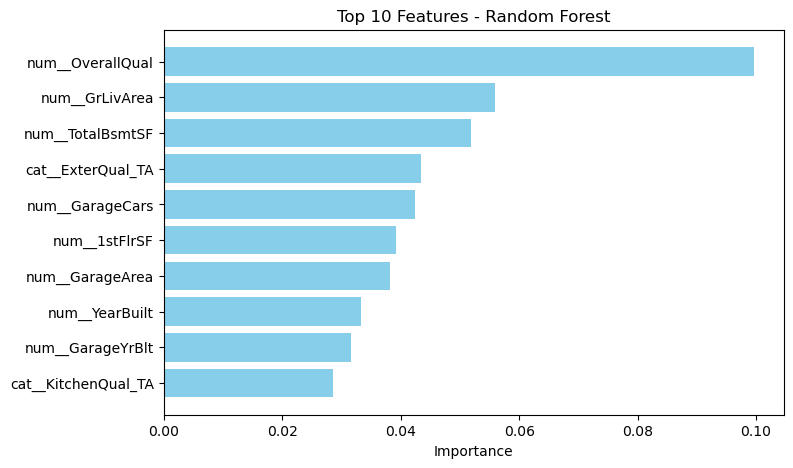

In [36]:
# Plot top 10 features
plt.figure(figsize=(8,5))
plt.barh(rf_feat_imp['Feature'], rf_feat_imp['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 10 Features - Random Forest")
plt.xlabel("Importance")
plt.show()

In [ ]:
cat_feature_names = cat_best.named_steps['preprocessor'].get_feature_names_out()
cat_importances = cat_best.named_steps['model'].get_feature_importance()

cat_feat_imp = pd.DataFrame({
    'Feature': cat_feature_names,
    'Importance': cat_importances
}).sort_values(by='Importance', ascending=False).head(10)

In [38]:
cat_feat_imp

,Feature,Importance
3,num__OverallQual,26.208946
15,num__GrLivArea,15.118882
11,num__TotalBsmtSF,6.171770
23,num__Fireplaces,3.740753
12,num__1stFlrSF,3.426332
2,num__LotArea,3.415200
8,num__BsmtFinSF1,2.761672
25,num__GarageCars,2.545098
26,num__GarageArea,2.502866
6,num__YearRemodAdd,2.132481


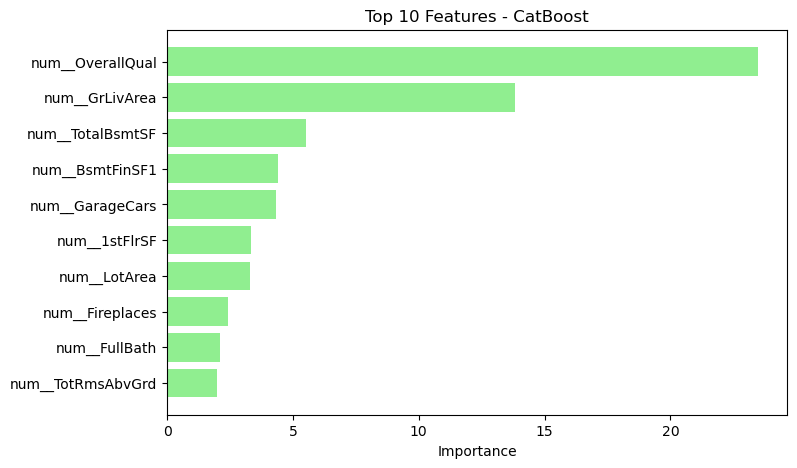

In [18]:

# Plot top 10 features
plt.figure(figsize=(8,5))
plt.barh(cat_feat_imp['Feature'], cat_feat_imp['Importance'], color='lightgreen')
plt.gca().invert_yaxis()
plt.title("Top 10 Features - CatBoost")
plt.xlabel("Importance")
plt.show()

Key Insights:

OverallQual dominates both models:

This indicates that the overall material and finish quality of the house is the most important factor affecting SalePrice.

Living area features are crucial:

GrLivArea, 1stFlrSF, and 2ndFlrSF appear in the top 10 for both models.

Larger living spaces naturally increase house value.

Garage and Basement features are important:

GarageCars, GarageArea, TotalBsmtSF, and BsmtFinSF1 appear consistently.

Shows that additional space and functionality contribute significantly to price.

Other notable features:

ExterQual_TA in RF and Fireplaces, LotArea in CatBoost also influence pricing.

CatBoost seems to capture more subtle factors (e.g., lot size and fireplaces) compared to RF.

Consistency across models:

Most top features overlap between Random Forest and CatBoost (OverallQual, GrLivArea, GarageCars, TotalBsmtSF, 1stFlrSF).

This confirms that these features are reliably important predictors of house price.